
# 🏫 University Cleanliness Simulation — 5×5 Grid (Multi-Agent)
This notebook simulates an **university with 25 rooms (5×5 grid)** where multiple agents (students, faculty, staff, etc.) move, act, and collectively influence **cleanliness**.  
It implements the exact rules we discussed:

- Each cell (room) has **cleanliness `s ∈ [0,1]`** (0 = very dirty, 1 = very clean).
- Each cell has **base traffic** (`[0,100)`) and a **memory cache** of recent actions.
- **Capacity per cell = 31 agents** (maximum).
- **Agents move** with a higher probability toward **cleaner neighboring rooms**.
- After moving to a room, an agent **chooses one action**: `clean`, `dirty`, or `do_nothing`.
- Then the agent **moves again** in the same cycle (as clarified).
- **Decision** is probabilistic (softmax) and depends on **room cleanliness** and **cache**.
- **Cache** is updated as an **EWMA** of recent actions: `+1` if cleaning, `-1` if dirtying, `0` if nothing.
- The simulation runs in **discrete cycles** until reaching **near-total cleanliness** or hitting a budget limit.
- **Outputs**: mean cleanliness per cycle (line plot), final cleanliness heatmap, and summary stats.



## ⚙️ Parameters
Tweak these to experiment:
- `GRID_SIZE` — grid dimension (5 → 5×5 rooms)
- `TOTAL_AGENTS` — total agents on the map (distributed with per-cell cap of 31)
- `MAX_PER_CELL` — capacity limit per cell (31)
- `MAX_CYCLES` — simulation budget (# of cycles)
- `CLEAN_STEP`, `DIRTY_STEP` — how much an action changes cleanliness
- `CACHE_ALPHA` — memory (EWMA) smoothing factor
- `STOP_THRESHOLD` — stop when **mean cleanliness ≥ threshold**
- `SEED` — reproducibility


In [4]:

from dataclasses import dataclass, field
from typing import List, Tuple
import numpy as np
import random

# -----------------------------
# Global Parameters (edit here)
# -----------------------------
GRID_SIZE = 5
TOTAL_AGENTS = 120      # total number of agents on the whole grid (you can change)
MAX_PER_CELL = 31       # capacity per cell
MAX_CYCLES = 200        # budget
CLEAN_STEP = 0.06       # how much cleanliness increases when cleaning
DIRTY_STEP = 0.05       # how much cleanliness decreases when dirtying
CACHE_ALPHA = 0.2       # EWMA for cache update
STOP_THRESHOLD = 0.99   # stop when mean cleanliness ≥ threshold
SEED = 42               # set None for fully random

if SEED is not None:
    random.seed(SEED)
    np.random.seed(SEED)



## 🧱 Environment and Agent Definitions
- `Cell`: holds cleanliness `s ∈ [0,1]`, base traffic `[0,100)`, cache, and list of agents.
- `Agent`: moves based on neighboring cleanliness, then acts (`clean/dirty/none`), then moves again.
- **Movement** preference: proportional to neighbor cleanliness, capacity-respecting.
- **Action** probabilities (softmax over scores):
  - `score_clean = s + cache`
  - `score_dirty = (1 - s) - cache`
  - `score_none = constant (e.g., 0.2)`


In [5]:

@dataclass
class Cell:
    x: int
    y: int
    cleanliness: float   # s in [0,1]
    base_traffic: int    # [0,100)
    cache: float = 0.0   # EWMA of recent actions (+1 clean, -1 dirty, 0 none)
    agents: List["Agent"] = field(default_factory=list)

@dataclass
class Agent:
    id: int
    x: int
    y: int
    # Propensities could be extended per-agent; for now decisions derive from s & cache.
    
    def softmax(self, scores: List[float]) -> np.ndarray:
        # Stable softmax
        s = np.array(scores, dtype=float)
        s = s - np.max(s)
        e = np.exp(s)
        return e / np.sum(e)
    
    def choose_action(self, cell: Cell, score_none: float = 0.2) -> str:
        s = cell.cleanliness
        c = cell.cache
        
        score_clean = s + c
        score_dirty = (1.0 - s) - c
        
        probs = self.softmax([score_clean, score_dirty, score_none])
        action = np.random.choice(["CLEAN", "DIRTY", "NONE"], p=probs)
        return action

class University:
    def __init__(self, grid_size: int = GRID_SIZE, total_agents: int = TOTAL_AGENTS, max_per_cell: int = MAX_PER_CELL):
        self.n = grid_size
        self.max_per_cell = max_per_cell
        
        # Initialize grid with random cleanliness and traffic
        self.grid: List[List[Cell]] = []
        for i in range(self.n):
            row = []
            for j in range(self.n):
                s = float(np.clip(np.random.uniform(0, 1), 0.0, 1.0))
                bt = int(np.random.randint(0, 100))
                row.append(Cell(x=i, y=j, cleanliness=s, base_traffic=bt))
            self.grid.append(row)
        
        # Place agents under per-cell capacity
        self.agents: List[Agent] = []
        count = 0
        while count < total_agents:
            i = np.random.randint(0, self.n)
            j = np.random.randint(0, self.n)
            if len(self.grid[i][j].agents) < self.max_per_cell:
                ag = Agent(id=count, x=i, y=j)
                self.grid[i][j].agents.append(ag)
                self.agents.append(ag)
                count += 1
            # else retry picking a different cell
    
    def neighbors(self, x: int, y: int) -> List[Tuple[int,int]]:
        nbrs = []
        if x > 0: nbrs.append((x-1, y))
        if x < self.n-1: nbrs.append((x+1, y))
        if y > 0: nbrs.append((x, y-1))
        if y < self.n-1: nbrs.append((x, y+1))
        return nbrs
    
    def move_agent_once(self, agent: Agent):
        # Choose neighbor based on cleanliness, subject to capacity
        nbrs = self.neighbors(agent.x, agent.y)
        if not nbrs:
            return  # single-cell world; nothing to do
        
        # Filter neighbors with available capacity
        valid = [(i,j) for (i,j) in nbrs if len(self.grid[i][j].agents) < self.max_per_cell]
        if not valid:
            return  # all neighbors full; stays in place
        
        # Movement preference proportional to cleanliness
        cleanliness_vals = np.array([self.grid[i][j].cleanliness for (i,j) in valid], dtype=float)
        # If all zero (extreme), fallback to uniform
        if np.all(cleanliness_vals <= 0.0):
            probs = np.ones(len(valid)) / len(valid)
        else:
            probs = cleanliness_vals / np.sum(cleanliness_vals)
        
        idx = np.random.choice(len(valid), p=probs)
        ni, nj = valid[idx]
        
        # Move agent
        self.grid[agent.x][agent.y].agents.remove(agent)
        agent.x, agent.y = ni, nj
        self.grid[ni][nj].agents.append(agent)
    
    def act_in_cell(self, agent: Agent):
        cell = self.grid[agent.x][agent.y]
        action = agent.choose_action(cell)
        
        if action == "CLEAN":
            cell.cleanliness = float(min(1.0, cell.cleanliness + CLEAN_STEP))
            # cache update (+1)
            cell.cache = (1.0 - CACHE_ALPHA) * cell.cache + CACHE_ALPHA * (+1.0)
        elif action == "DIRTY":
            cell.cleanliness = float(max(0.0, cell.cleanliness - DIRTY_STEP))
            # cache update (-1)
            cell.cache = (1.0 - CACHE_ALPHA) * cell.cache + CACHE_ALPHA * (-1.0)
        else:
            # NONE: no cleanliness change, small decay toward 0 to avoid bias accumulation
            cell.cache = (1.0 - CACHE_ALPHA) * cell.cache + CACHE_ALPHA * (0.0)
    
    def mean_cleanliness(self) -> float:
        vals = [cell.cleanliness for row in self.grid for cell in row]
        return float(np.mean(vals))
    
    def agent_counts(self) -> np.ndarray:
        counts = np.zeros((self.n, self.n), dtype=int)
        for i in range(self.n):
            for j in range(self.n):
                counts[i, j] = len(self.grid[i][j].agents)
        return counts

    def run_cycle(self):
        # One full cycle per agent: move -> act -> move (as clarified)
        for agent in self.agents:
            self.move_agent_once(agent)
            self.act_in_cell(agent)
            self.move_agent_once(agent)



## 🔁 Simulation Loop
- Runs for `MAX_CYCLES` or until mean cleanliness ≥ `STOP_THRESHOLD`.
- Tracks mean cleanliness per cycle for plotting.
- Returns history and final grid state.


In [6]:

def run_simulation(max_cycles: int = MAX_CYCLES, verbose: bool = True):
    uni = University(grid_size=GRID_SIZE, total_agents=TOTAL_AGENTS, max_per_cell=MAX_PER_CELL)
    history = []
    
    for t in range(max_cycles):
        uni.run_cycle()
        mc = uni.mean_cleanliness()
        history.append(mc)
        if verbose and (t % 10 == 0 or t == max_cycles-1):
            print(f"Cycle {t:3d} | Mean cleanliness: {mc:.4f}")
        if mc >= STOP_THRESHOLD:
            if verbose:
                print(f"✅ Stop at cycle {t}: target reached (mean ≥ {STOP_THRESHOLD})")
            break
    return uni, np.array(history)



## 📊 Visualization
- **Line plot** of mean cleanliness across cycles.
- **Heatmap** of final cleanliness (5×5).
> Note: We use **matplotlib** (no seaborn), one chart per cell, and no explicit color settings.


In [7]:

import matplotlib.pyplot as plt

def plot_history(history: np.ndarray):
    plt.figure(figsize=(6,4))
    plt.plot(history)
    plt.xlabel("Cycle")
    plt.ylabel("Mean cleanliness")
    plt.title("Mean cleanliness over time")
    plt.grid(True)
    plt.show()

def plot_heatmap(uni: University):
    # Build matrix of cleanliness
    mat = np.array([[uni.grid[i][j].cleanliness for j in range(uni.n)] for i in range(uni.n)])
    plt.figure(figsize=(4.8,4.8))
    plt.imshow(mat, vmin=0.0, vmax=1.0)
    plt.colorbar(label="Cleanliness (0=dirty, 1=clean)")
    plt.title("Final cleanliness heatmap (5×5)")
    plt.xticks(range(uni.n))
    plt.yticks(range(uni.n))
    plt.show()

def summarize(uni: University, history: np.ndarray):
    counts = uni.agent_counts()
    print("Final mean cleanliness:", float(history[-1]))
    print("\nAgent counts per cell (cap=31):")
    print(counts)
    print("\nFinal cache (rounded):")
    for i in range(uni.n):
        row_cache = [f"{uni.grid[i][j].cache:.2f}" for j in range(uni.n)]
        print(" ".join(row_cache))


ModuleNotFoundError: No module named 'matplotlib'


## ▶️ Run an Experiment
Feel free to change the **global parameters** above and re-run this cell.


Cycle   0 | Mean cleanliness: 0.4285
Cycle  10 | Mean cleanliness: 0.3931
Cycle  20 | Mean cleanliness: 0.3750
Cycle  30 | Mean cleanliness: 0.3309
Cycle  40 | Mean cleanliness: 0.3637
Cycle  50 | Mean cleanliness: 0.3621
Cycle  60 | Mean cleanliness: 0.3524
Cycle  70 | Mean cleanliness: 0.3252
Cycle  80 | Mean cleanliness: 0.3256
Cycle  90 | Mean cleanliness: 0.3256
Cycle 100 | Mean cleanliness: 0.3204
Cycle 110 | Mean cleanliness: 0.3236
Cycle 120 | Mean cleanliness: 0.3216
Cycle 130 | Mean cleanliness: 0.3120
Cycle 140 | Mean cleanliness: 0.2944
Cycle 150 | Mean cleanliness: 0.2856
Cycle 160 | Mean cleanliness: 0.2480
Cycle 170 | Mean cleanliness: 0.2364
Cycle 180 | Mean cleanliness: 0.2456
Cycle 190 | Mean cleanliness: 0.2464
Cycle 199 | Mean cleanliness: 0.2456


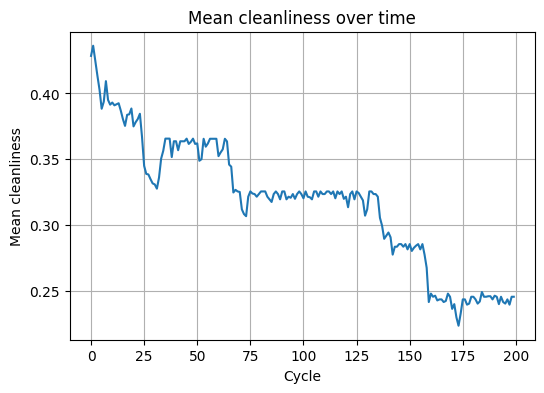

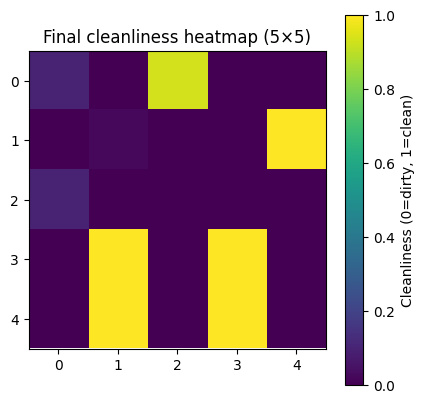

Final mean cleanliness: 0.2455746742441081

Agent counts per cell (cap=31):
[[ 0  0  0  0 11]
 [ 0  0  0  9 19]
 [ 0  0  0  0  3]
 [ 0 25  0 24  0]
 [ 0 15  0 14  0]]

Final cache (rounded):
-0.75 -0.81 0.33 -0.76 -0.76
-0.72 0.00 -0.78 -0.95 0.51
-0.68 -0.31 -0.80 -0.70 -0.83
-0.82 0.88 -0.56 0.79 -0.85
-0.92 0.84 -0.93 0.90 -0.77


: 

In [ ]:

uni, hist = run_simulation(MAX_CYCLES, verbose=True)
plot_history(hist)
plot_heatmap(uni)
summarize(uni, hist)



## 🧠 Extensions (Optional Ideas)
- Add **roles** (student / faculty / staff / janitor) with different action scores.
- Let **`CLEAN_STEP` / `DIRTY_STEP`** depend on `base_traffic` (busy rooms dirtier faster).
- Add **animation** to visualize agent flows across time.
- Track **distribution of cache values** and correlate with cleanliness.
- Experiment with **heterogeneous agents** (some inherently cleaner/messier).
